In [106]:
%matplotlib inline

import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import truncnorm

# Signal-in-white-noise model: simulation with a uniform prior

## Construction of the data

In [143]:
N = 300 # number of observed coefficients
tau = 0.75
n = 200 # size of the dataset
m = 40 # number of machines
alpha = 1.75 # smoothness parameter
sigma = 1

### True signals

In [144]:
# from the uniform prior
theta_1 = tau * (np.random.random(N) * 2 - 1) / (np.arange(1,N+1,1) ** (alpha + 0.5))

# from Szabo 15
theta_2 = np.sin(10 * np.arange(1,N+1,1)) / (np.arange(1,N+1,1)) ** 2.25

# from Szabo 17
theta_3 = np.sin(np.arange(1.0,N+1.0,1.0)) * np.sqrt(2) / (np.arange(1.0,N+1.0,1.0)) ** 1.5

In [145]:
np.sum(np.sin(np.arange(1.0,N+1.0,1.0)) * np.sqrt(2) / (np.arange(1.0,N+1.0,1.0)) ** 1.5)

1.4855855037514711

<Figure size 432x288 with 0 Axes>

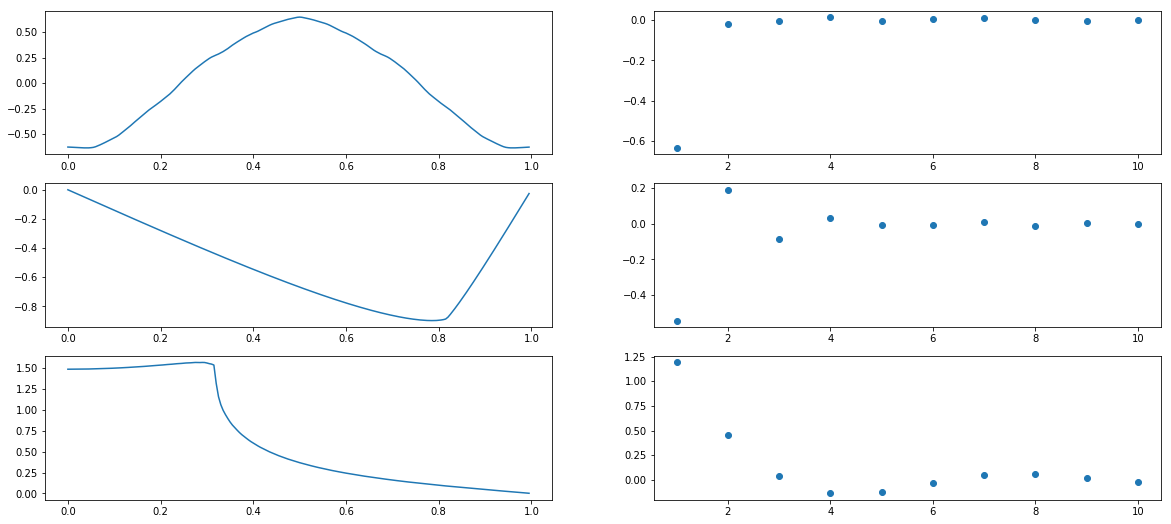

In [146]:
# plot of the signal and the coefficients

plt.figure()

fig, ax = plt.subplots(3,2, figsize=(20/1,9/1))

a = ax[0,0]
X = np.arange(0,1,0.005)
Y = [np.sum(theta_1[:N//2] * np.cos(2*np.pi*(np.arange(1,N//2+1,1) * x)))
     + np.sum(theta_1[N//2:] * np.sin(2*np.pi*(np.arange(1,N//2+1,1) * x))) for x in X]
a.plot(X,Y)

a = ax[0,1]
K = np.arange(1,N+1,1)
a.plot(K[:10],theta_1[:10],'o')

a = ax[1,0]
Y = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,Y)

a = ax[1,1]
K = np.arange(1,N+1,1)
a.plot(K[:10],theta_2[:10],'o')

a = ax[2,0]
Y = [np.sum(theta_3 * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
a.plot(X,Y)

a = ax[2,1]
K = np.arange(1,N+1,1)
a.plot(K[:10],theta_3[:10],'o')

### Generates noisy samples

In [147]:
# generates m samples of the first N coefficients

def generate_data(theta=theta_2, m=m):

    return np.tile(theta_2, (m,1)) + np.sqrt(sigma * m / n) * np.random.normal(size=(m,N))


data = generate_data(theta_2, m)

## Posterior distribution

Non-adaptive case: $\alpha$ and $\tau$ are chosen as the optimal values.

### Naive averaging

With a uniform prior, local posterior distributions are truncated normals (simulation with the library truncnorm)

In [148]:
# Sample p values from each local posterior distribution

p = 400

post = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = tau / (i ** (alpha + 0.5))
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data[j,i-1], scale = sigma * np.sqrt(m/n), size=p)
        
    post[i-1,] = np.mean(samp, axis = 0)

In [149]:
# Sample p values from each local posterior distribution with Gaussian prior

p = 400

post_gauss = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        samp[j,] = np.random.normal(loc = data[j,i-1] * n / (n + sigma ** 2 * m * i ** (1 + 2*alpha)),
                                                             scale = sigma ** 2 * m / (n + sigma ** 2 * m * i ** (1 + 2*alpha)),
                                                                                       size=p)
        
    post_gauss[i-1,] = np.mean(samp, axis = 0)
    
# Comparison with the non-distributed case

post_gauss_nd = np.zeros((N,p))

for i in range(1, N+1):
        
    post_gauss_nd[i-1,] = np.random.normal(loc = np.mean(data[:,i-1]) * n / (n + sigma ** 2 * m * i ** (1 + 2*alpha)),
                                           scale = sigma / np.sqrt(n + sigma * i ** (1 + 2*alpha)), size=p)

In [150]:
# Comparison with the non-distributed case

post_nd = np.zeros((N,p))

for i in range(1, N+1):
        
    born = tau / (i ** (2 * alpha + 1))
        
    post_nd[i-1,] = truncnorm.rvs(-born, born, loc = np.mean(data[:,i-1]), scale = sigma / np.sqrt(n), size=p)

<Figure size 432x288 with 0 Axes>

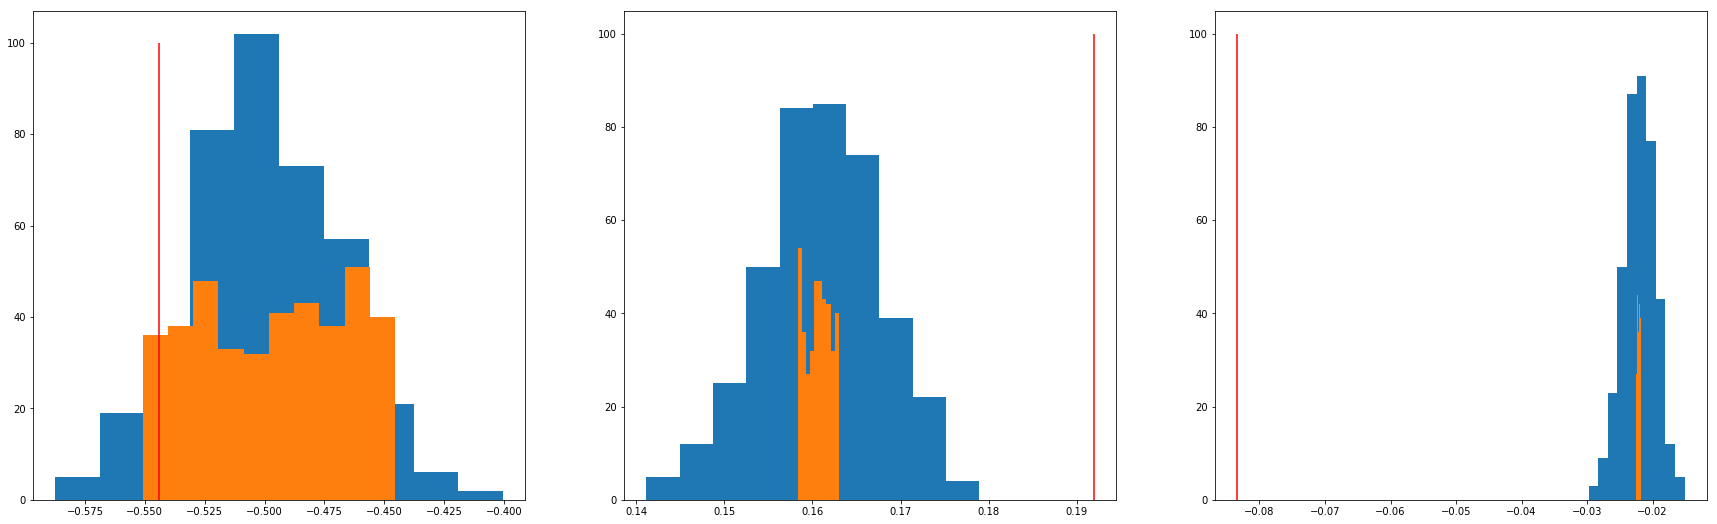

In [151]:
# Plots of the global posterior densities of the first coefficients

plt.figure()

fig, ax = plt.subplots(1,3, figsize=(30/1,9/1))

a = ax[0]
a.hist(post[0,], bins = 10)
a.hist(post_nd[0,], bins = 10)
a.vlines((theta_2[0]), 0, 100, colors=("red"))

a = ax[1]
a.hist(post[1,], bins = 10)
a.hist(post_nd[1,], bins = 10)
a.vlines((theta_2[1]), 0, 100, colors=("red"))

a = ax[2]
a.hist(post[2,], bins = 10)
a.hist(post_nd[2,], bins = 10)
a.vlines((theta_2[2]), 0, 100, colors=("red"))

<Figure size 432x288 with 0 Axes>

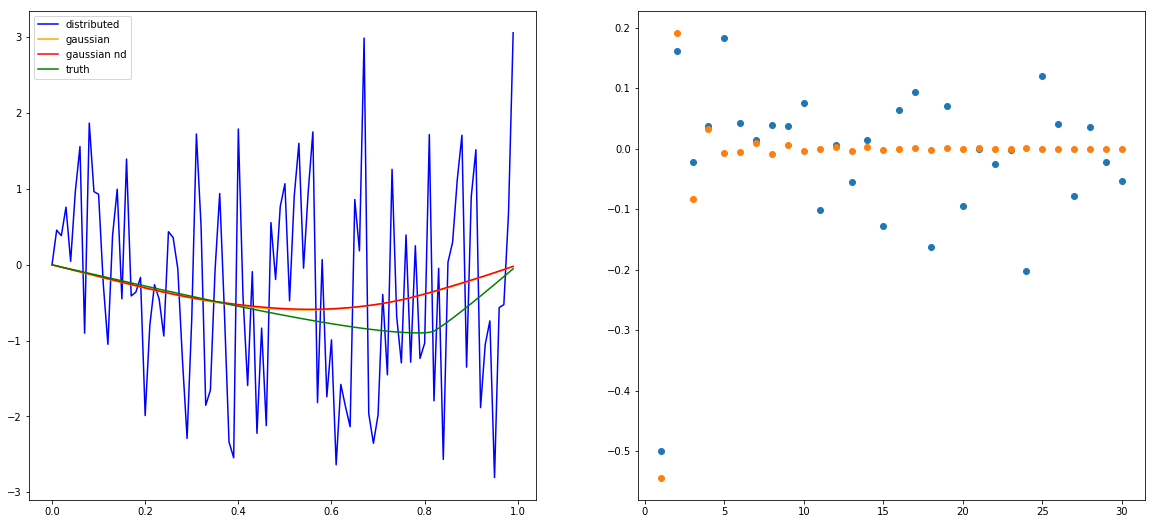

In [152]:
# Estimation of the coefficients and the signal

est_coeff = np.mean(post, axis = 1)
est_coeff_nd = np.mean(post_nd, axis = 1)
est_coeff_gauss = np.mean(post_gauss, axis = 1)
est_coeff_gauss_nd = np.mean(post_gauss_nd, axis = 1)

plt.figure()

fig, ax = plt.subplots(1,2, figsize=(20/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
Y = [np.sum(est_coeff * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_gauss = [np.sum(est_coeff_gauss * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_gauss_nd = [np.sum(est_coeff_gauss_nd * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_nd = [np.sum(est_coeff_nd * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_true = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,Y,color="blue",label="distributed")
#a.plot(X,Y_nd,color="red",label="non distributed")
a.plot(X,Y_gauss,color="orange",label="gaussian")
a.plot(X,Y_gauss_nd,color="red",label="gaussian nd")
a.plot(X,Y_true,color="green",label="truth")
a.legend()

a = ax[1]
K = np.arange(1,N+1,1)
a.plot(K[:30],est_coeff[:30],'o')
a.plot(K[:30],theta_2[:30],'o')

Like in the Gaussian case, doesn't work well (unless there is an error in the previous lines)

### Adjusted likelihoods and averaging

The local likelihoods are raised to the power m. Because they are normal, their variance is thus multiplied by $\sqrt m$.

<Figure size 432x288 with 0 Axes>

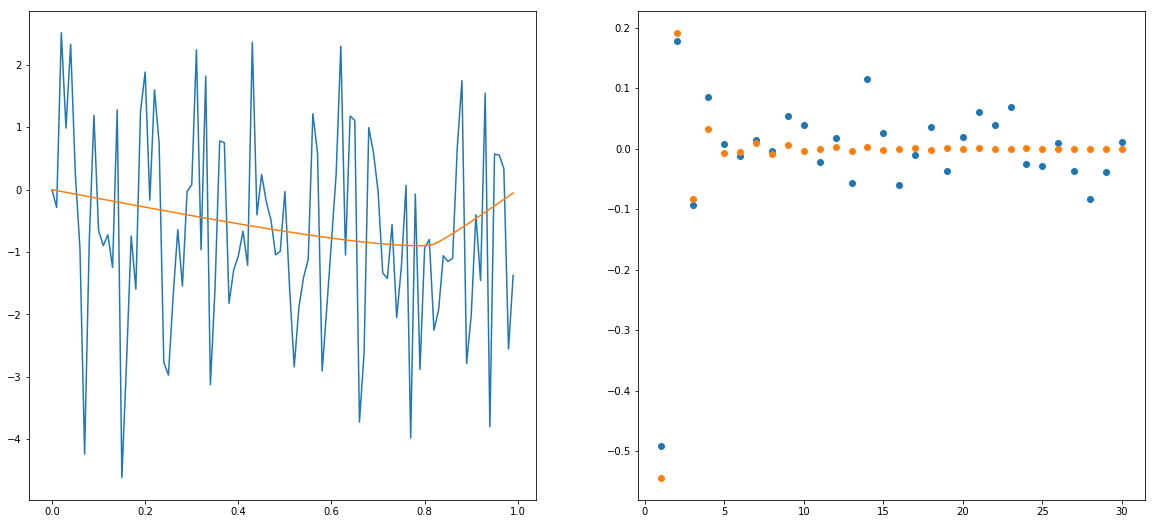

In [81]:
p = 400

post_padj = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = tau / (i ** (alpha + 1))
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data[j,i-1], scale = sigma * m / np.sqrt(n), size=p)
        
    post_padj[i-1,] = np.mean(samp, axis = 0)
    
est_coeff_padj = np.mean(post_padj, axis = 1)

plt.figure()

fig, ax = plt.subplots(1,2, figsize=(20/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
Y = [np.sum(est_coeff_padj * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_true = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_true)

a = ax[1]
K = np.arange(1,N+1,1)
a.plot(K[:30],est_coeff_padj[:30],'o')
a.plot(K[:30],theta_2[:30],'o')

### Adjusted priors and averaging

The generalized local posterior raised to the power m the prior. We still have truncated normals with differents bounds.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4846: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)


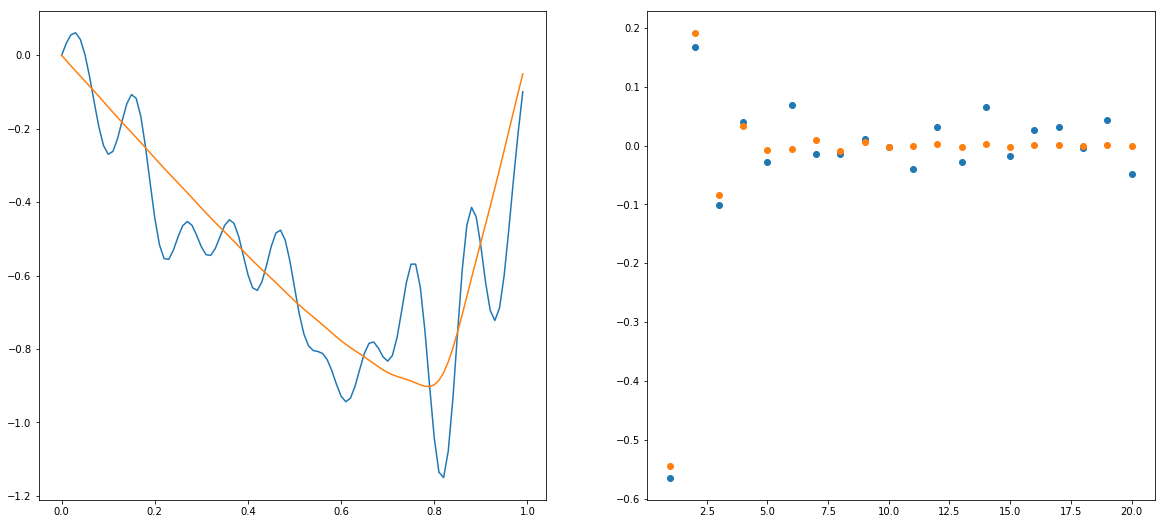

In [284]:
p = 400

post_padj = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = (tau / (i ** (alpha + 1))) ** m
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data[j,i-1], scale = sigma * np.sqrt(m/n), size=p)
        
    post_padj[i-1,] = np.mean(samp, axis = 0)
    
est_coeff_padj = np.mean(post_padj, axis = 1)

plt.figure()

fig, ax = plt.subplots(1,2, figsize=(20/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
Y = [np.sum(est_coeff_padj * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_true = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_true)

a = ax[1]
K = np.arange(1,N+1,1)
a.plot(K[:30],est_coeff_padj[:30],'o')
a.plot(K[:30],theta_2[:30],'o')